In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders, get_FMNIST_loaders, get_CIFAR100_loaders, get_CIFAR10_loaders
from lib.model import ANN
from lib.train import train
from lib.test import test
from lib.growth_schedules import get_handcrafted_schedule
from lib.visualize import (visualize_pathes,
                          visualize_statistical_reliability,
                          visualize_box_plot)               

import os
import numpy as np

In [2]:
device = get_device()

In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"

# MNIST

## Get data loaders

In [4]:
batch_size=128

In [5]:
train_loader, val_loader, test_loader = get_MNIST_loaders(data_path, range(10), batch_size)

## Random Initialization

In [6]:
init_name = "random"
savefig = "MNIST_random"

### Define, train and test both root & target models

In [7]:
# Network's initial architecture
num_inputs = 28*28
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 5

#### Root model

In [8]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


In [9]:
test_acc_roots

[43.04910256410257,
 30.108589743589746,
 64.69346153846156,
 49.84935897435898,
 46.71474358974359]

#### Target model

In [10]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|██████████| 3/3 [00:21<00:00,  7.33s/it]


In [11]:
test_acc_targets

[94.19141025641026,
 93.3991025641026,
 93.06858974358977,
 93.6997435897436,
 93.53974358974357]

### Grow root model

In [12]:
# Growth parameters
num_neurons = 9

In [13]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [14]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


In [15]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results

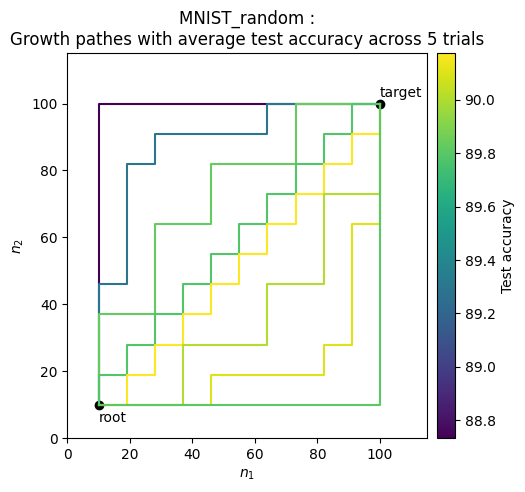

In [16]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, savefig)

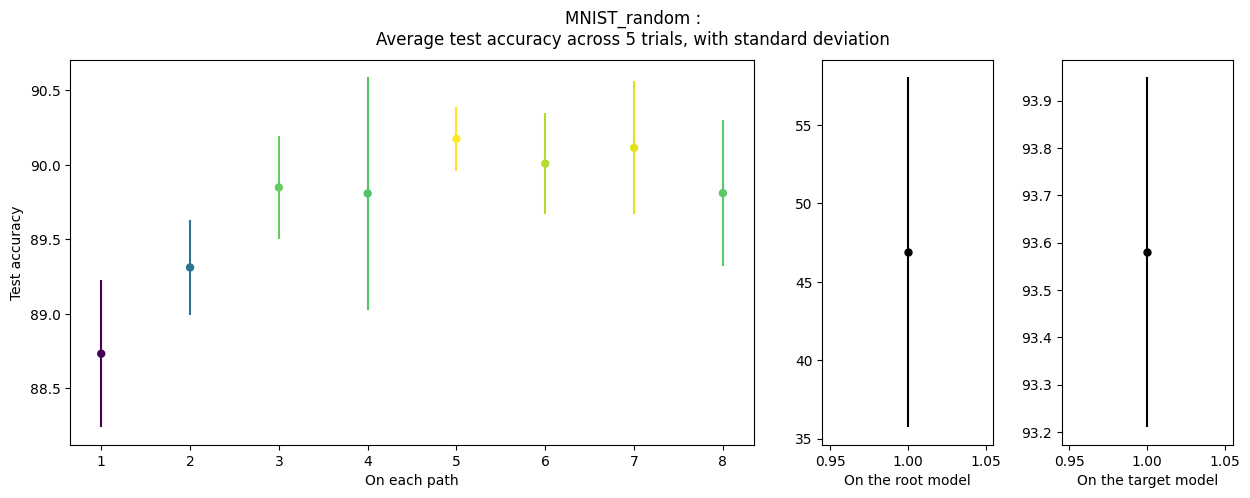

In [17]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True, savefig=savefig)

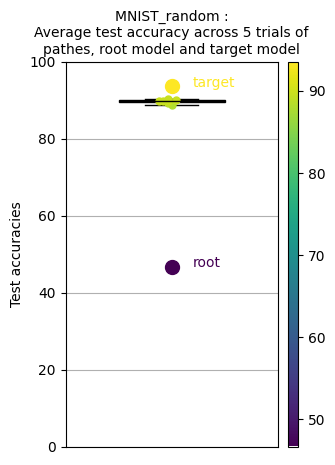

In [18]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target, savefig)

## GradMax Initialization

In [19]:
init_name = "gradmax"
savefig = "MNIST_gradmax"

### Define, train and test both root & target models

In [20]:
# Network's initial architecture
num_inputs = 28*28
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 5

#### Root model

In [21]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|██████████| 3/3 [00:10<00:00,  3.55s/it]


In [22]:
test_acc_roots

[33.552820512820524,
 38.00025641025641,
 27.574358974358972,
 40.02346153846153,
 48.66782051282051]

#### Target model

In [23]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


In [24]:
test_acc_targets

[94.11064102564104,
 93.86974358974359,
 93.86038461538462,
 93.68,
 93.15884615384617]

### Grow root model

In [25]:
# Growth parameters
num_neurons = 9

In [26]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [27]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


In [28]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results

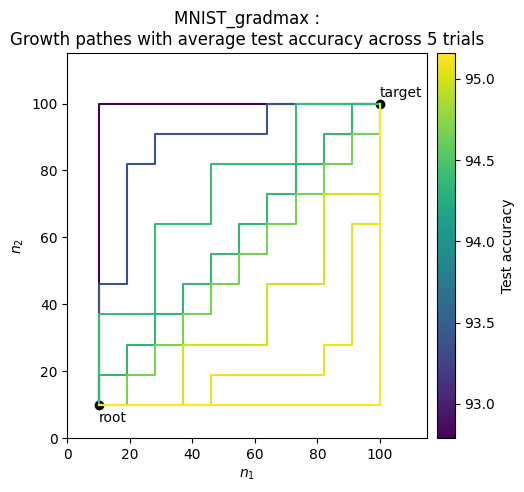

In [29]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, savefig)

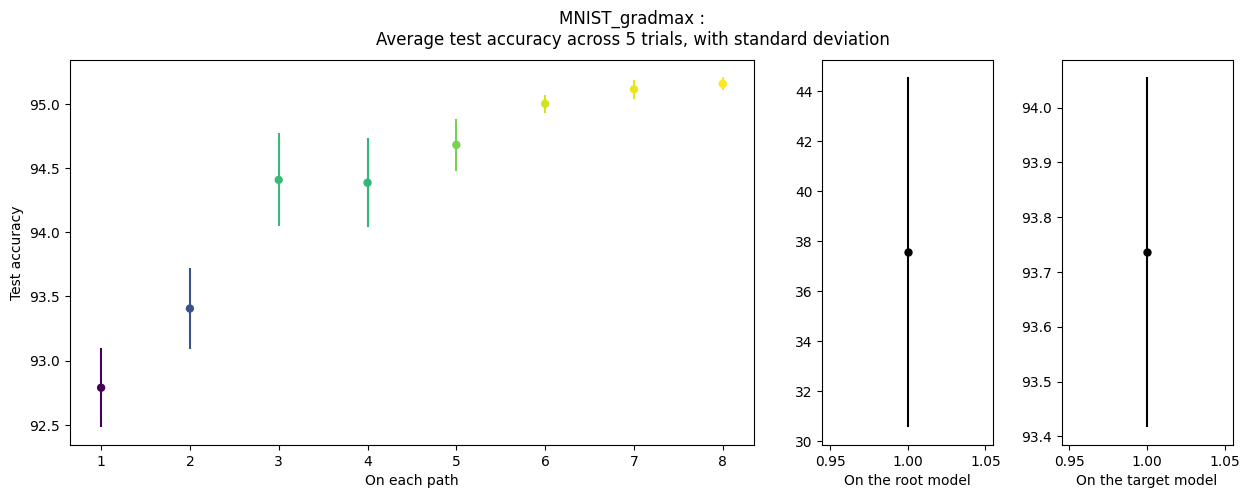

In [30]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True, savefig=savefig)

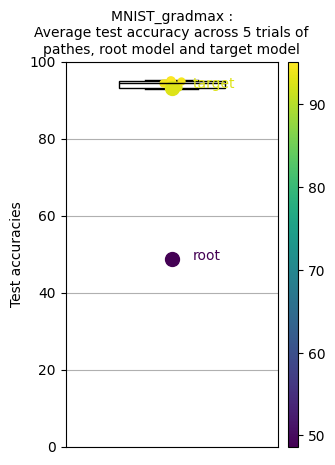

In [31]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target, savefig)

# FMNIST

## Get data loaders

In [32]:
batch_size=128

In [33]:
train_loader, val_loader, test_loader = get_FMNIST_loaders(data_path, range(10), batch_size)

## Random Initialization

In [34]:
init_name = "random"
savefig = "FNIST_random"

### Define, train and test both root & target models

In [35]:
# Network's initial architecture
num_inputs = 28*28
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 5

#### Root model

In [36]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|██████████| 3/3 [00:10<00:00,  3.62s/it]


In [37]:
test_acc_roots

[55.22871794871795,
 70.74307692307691,
 38.45128205128204,
 70.30256410256412,
 54.718076923076936]

#### Target model

In [38]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


In [39]:
test_acc_targets

[83.60384615384615,
 83.52397435897433,
 83.31256410256415,
 83.46346153846152,
 83.43397435897433]

### Grow root model

In [40]:
# Growth parameters
num_neurons = 9

In [41]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [42]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


In [43]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results

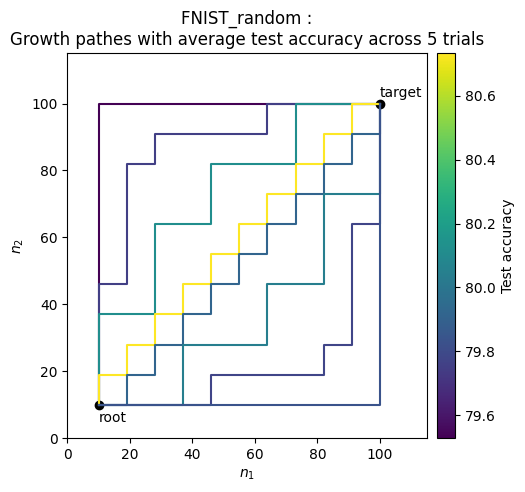

In [44]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, savefig)

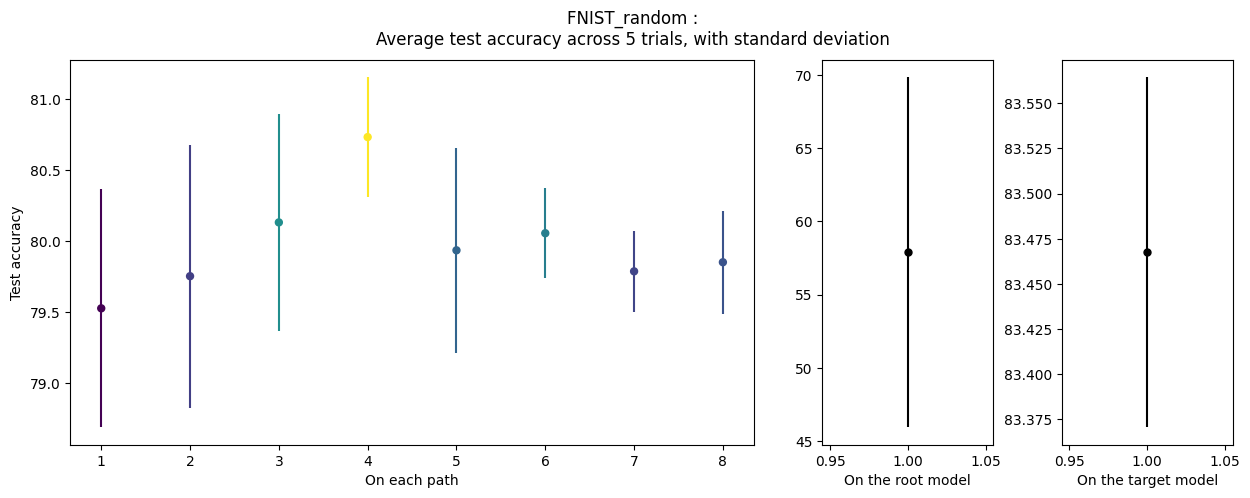

In [45]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True, savefig=savefig)

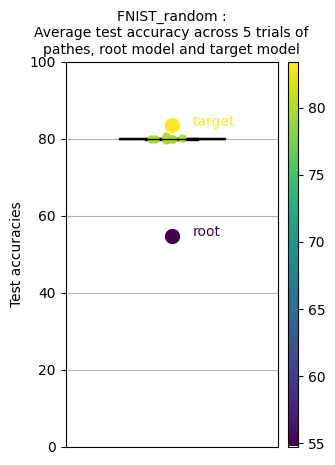

In [46]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target, savefig)

## GradMax Initialization

In [47]:
init_name = "gradmax"
savefig = "FMNIST_gradmax"

### Define, train and test both root & target models

In [48]:
# Network's initial architecture
num_inputs = 28*28
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 5

#### Root model

In [49]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|██████████| 3/3 [00:10<00:00,  3.62s/it]


In [50]:
test_acc_roots

[40.63487179487179,
 53.745641025641035,
 67.60807692307692,
 63.28089743589742,
 60.787564102564104]

#### Target model

In [51]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


In [52]:
test_acc_targets

[83.71397435897435,
 83.80423076923077,
 82.80269230769231,
 83.9347435897436,
 83.09320512820516]

### Grow root model

In [53]:
# Growth parameters
num_neurons = 9

In [54]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [55]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


In [56]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results

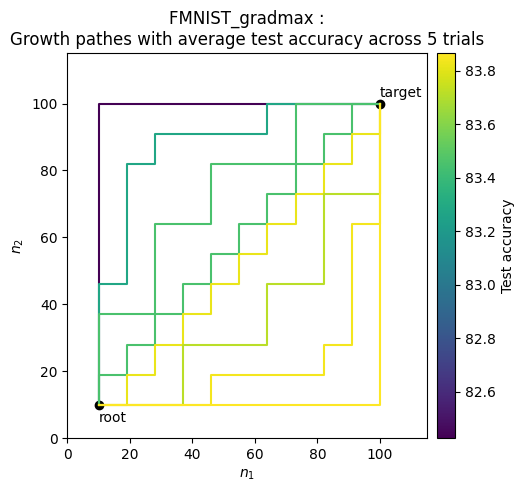

In [57]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, savefig)

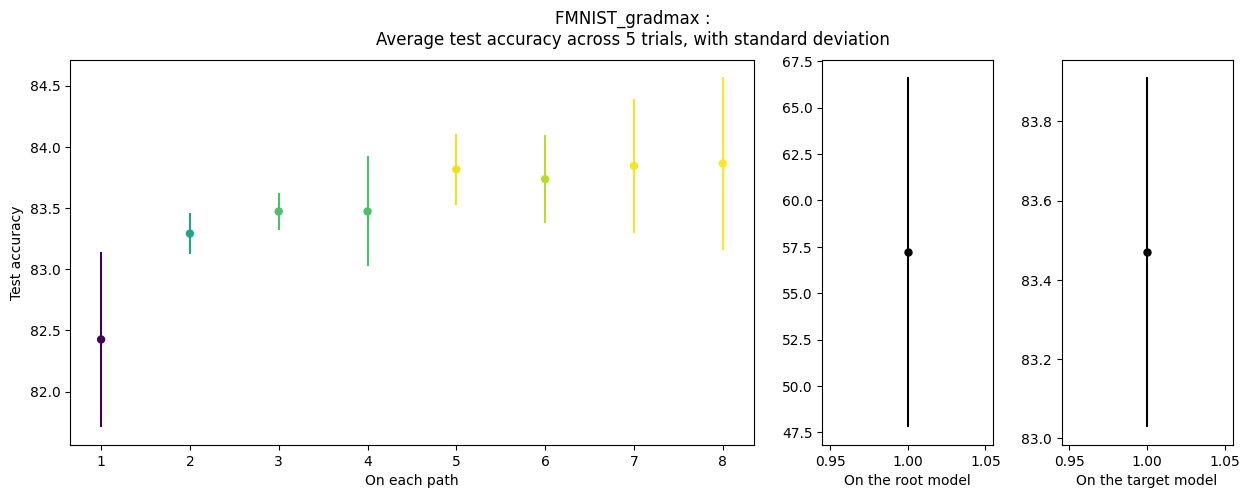

In [58]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True, savefig=savefig)

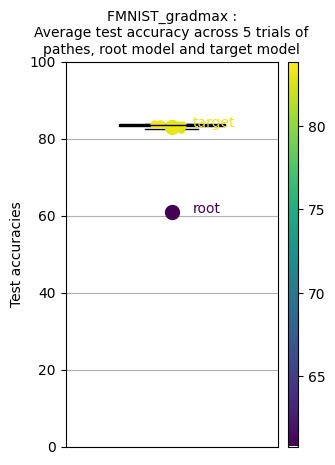

In [59]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target, savefig)

# CIFAR 10

## Get data loaders

In [60]:
batch_size=128

In [61]:
train_loader, val_loader, test_loader = get_CIFAR10_loaders(data_path, range(10), batch_size)

## Random Initialization

In [62]:
init_name = "random"
savefig = "CIFAR10_random"

### Define, train and test both root & target models

In [65]:
# Network's initial architecture
num_inputs = 32*32*3
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 5

#### Root model

In [66]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


In [67]:
test_acc_roots

[25.881282051282056,
 23.477435897435896,
 25.830769230769224,
 23.818717948717953,
 20.452692307692306]

#### Target model

In [68]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


In [69]:
test_acc_targets

[39.623846153846145,
 39.49294871794871,
 40.03346153846154,
 40.254487179487185,
 40.30435897435897]

### Grow root model

In [70]:
# Growth parameters
num_neurons = 9

In [71]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [72]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|██████████| 3/3 [00:28<00:00,  9.60s/it]


In [73]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results

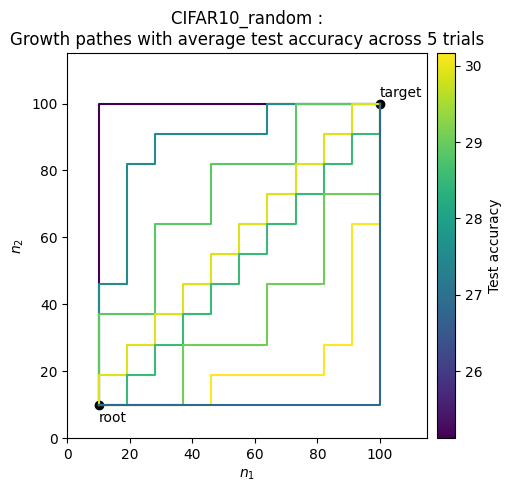

In [74]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, savefig)

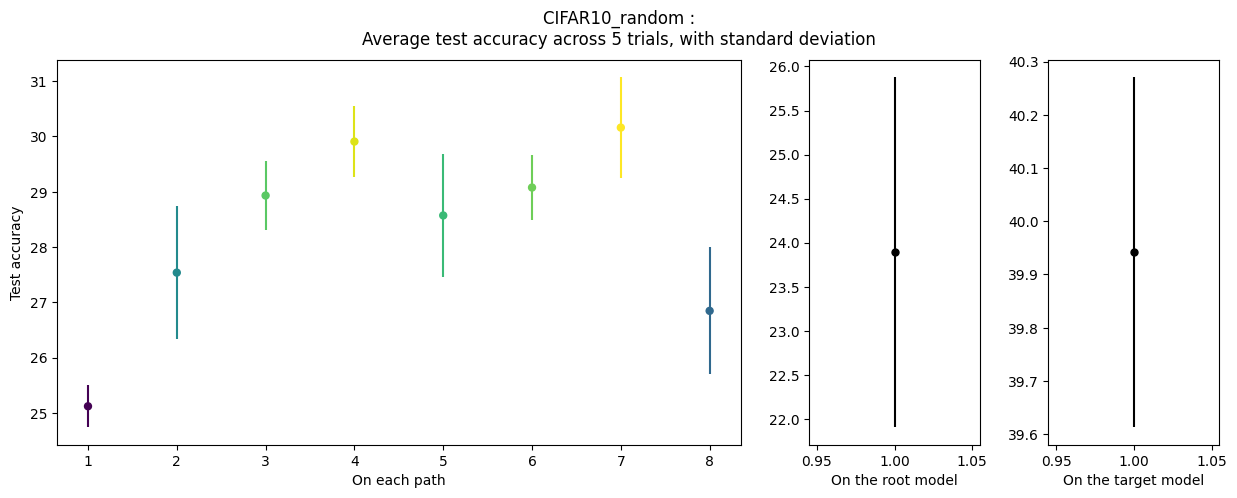

In [75]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True, savefig=savefig)

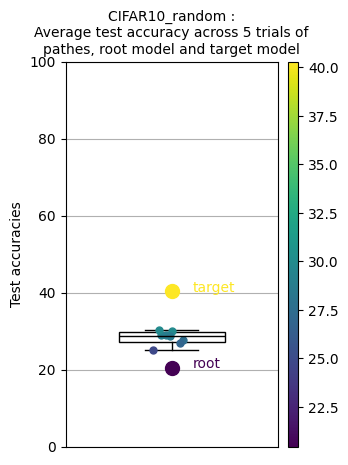

In [76]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target, savefig)

## GradMax Initialization

In [77]:
init_name = "gradmax"
savefig = "CIFAR10_gradmax"

### Define, train and test both root & target models

In [78]:
# Network's initial architecture
num_inputs = 32*32*3
num_hidden = 10
num_outputs = 10

# Network's final architecture
num_hidden_target = 100

# Loss & optimizer
loss_name = "MSE" # "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 5e-3
growth_schedule = None

# Experiment parameters
num_repetitions = 5

#### Root model

In [79]:
test_acc_roots = []
for i in range(num_repetitions) :
    root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
    _ = train(root_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_root = test(root_model, test_loader, batch_size, device)
    test_acc_roots.append(test_acc_root)

100%|██████████| 3/3 [00:27<00:00,  9.18s/it]


In [80]:
test_acc_roots

[27.383974358974356,
 24.469487179487178,
 25.45064102564102,
 23.678076923076933,
 28.255256410256415]

#### Target model

In [81]:
test_acc_targets = []
for i in range(num_repetitions) :
    target_model = ANN(num_inputs, num_hidden_target, num_outputs).to(device)
    _ = train(target_model, num_outputs, growth_schedule, loss_name, optimizer_name, lr, train_loader, val_loader, num_epochs, batch_size, device, verbose=0)
    test_acc_target = test(target_model, test_loader, batch_size, device)
    test_acc_targets.append(test_acc_target)

100%|██████████| 3/3 [00:28<00:00,  9.47s/it]


In [82]:
test_acc_targets

[39.762948717948724,
 40.52423076923077,
 39.934230769230766,
 39.463205128205125,
 40.26423076923076]

### Grow root model

In [83]:
# Growth parameters
num_neurons = 9

In [84]:
growth_schedules = get_handcrafted_schedule(num_neurons)

In [85]:
test_accs_repeted = []
for i in range(num_repetitions) :
    test_accs = []
    for growth_schedule in growth_schedules :
        root_model = ANN(num_inputs, num_hidden, num_outputs).to(device)
        _ = train(root_model,
                  num_outputs,
                  growth_schedule,
                  loss_name, 
                  optimizer_name, lr, 
                  train_loader, val_loader, 
                  num_epochs, batch_size, 
                  device,
                  init_name=init_name,
                  verbose=0)
        test_acc = test(root_model, test_loader, batch_size, device)
        test_accs.append(test_acc)
    test_accs_repeted.append(test_accs)

100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


In [86]:
test_accs_repeted = np.array(test_accs_repeted)
test_accs = np.mean(test_accs_repeted, 0)

### Visualize results

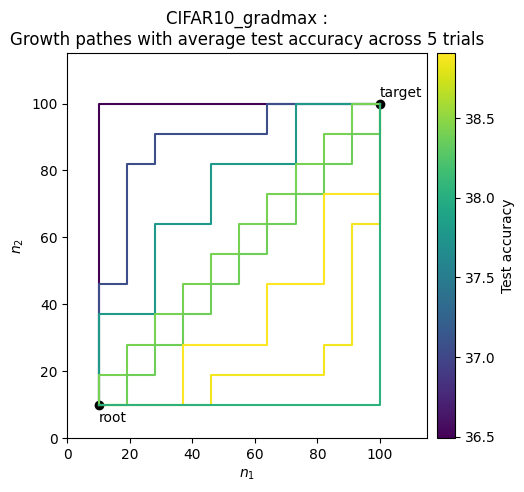

In [87]:
visualize_pathes(num_hidden, num_hidden_target, growth_schedules, test_accs, savefig)

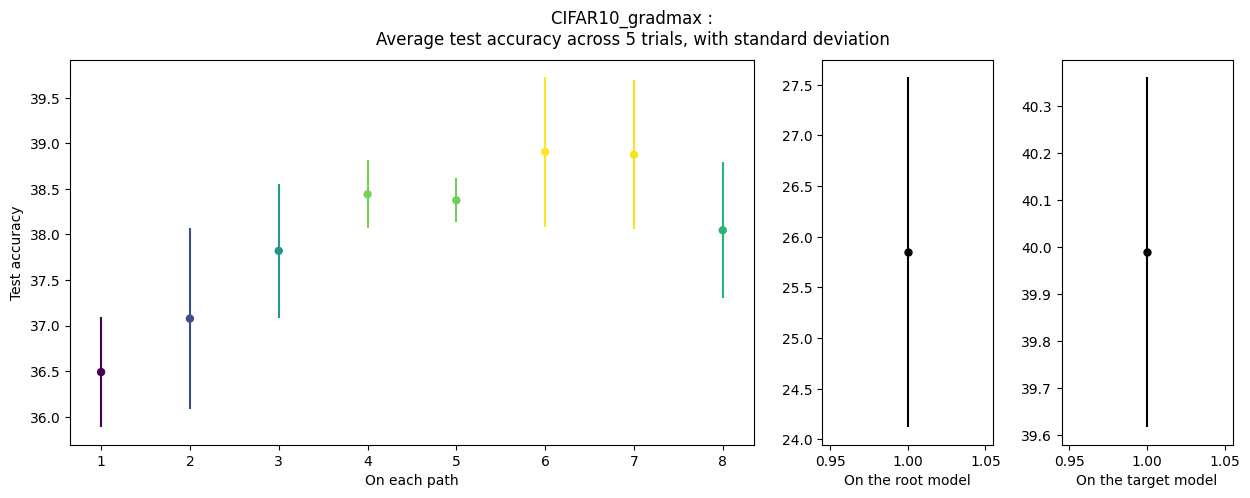

In [88]:
visualize_statistical_reliability (test_accs_repeted, test_accs, test_acc_roots, test_acc_targets,
                                   free_lim=True, savefig=savefig)

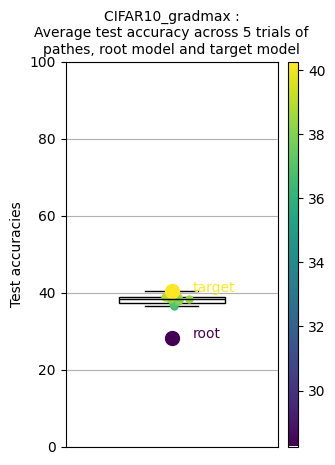

In [89]:
visualize_box_plot(test_accs, test_acc_root, test_acc_target, savefig)